In [31]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [44]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [45]:
small_ceo_df = ceo_df[ceo_df['size_category'] == 'Small']
medium_ceo_df = ceo_df[ceo_df['size_category'] == 'Medium']
large_ceo_df = ceo_df[ceo_df['size_category'] == 'Large']

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 3979 to 113142
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticker           3299 non-null   object 
 1   bonus            3299 non-null   float64
 2   stock_awards     3299 non-null   float64
 3   option_awards    3299 non-null   float64
 4   othcomp          3299 non-null   float64
 5   age              3299 non-null   float64
 6   tdc1             3299 non-null   float64
 7   year             3299 non-null   int64  
 8   becameceo        3299 non-null   float64
 9   joined_co        555 non-null    float64
 10  leftofc          1463 non-null   float64
 11  gender           3299 non-null   object 
 12  cusip            3299 non-null   int64  
 13  naicsdesc        3299 non-null   int64  
 14  sic              3299 non-null   int64  
 15  mkvalt           3299 non-null   float64
 16  size_category    3299 non-null   object 
 17  signature

In [46]:
df =  large_ceo_df
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2','gvkey', 'salary', 'total_curr', 
         'bonus', 'stock_awards', 'option_awards', 'othcomp'], axis=1, inplace=True)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['year'] >= 2010) & (df['year'] <= 2016)]
holdout_mask = df.loc[(df['year'] >= 2017) & (df['year'] <= 2019)]

y = np.log(train_mask.tdc1)
X = train_mask.drop('tdc1', axis=1)

VarY = holdout_mask[['signature_index', 'tdc1']]
VarY.to_csv('./Saved/large_ceo_df.csv', index=False)

holdout_set = holdout_mask


holdout_X = holdout_set.drop(['signature_index', 'tdc1'], axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

missing_cols = set(X_train.columns) - set(holdout_X.columns)
for col in missing_cols:
    holdout_X[col] = 0
holdout_X = holdout_X[X_train.columns]

/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_3717/3569615602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2','gvkey', 'salary', 'total_curr',


In [47]:
cv = KFold(10)

In [48]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['gender']),
    remainder="drop",
)
# pipe = Pipeline([('columntransformer',preproc_pipe),
#                  ('feature_select',SelectKBest()), 
#                  ('clf', Ridge())
#                 ])

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [53]:
alphas = list(np.linspace(0, 1000, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

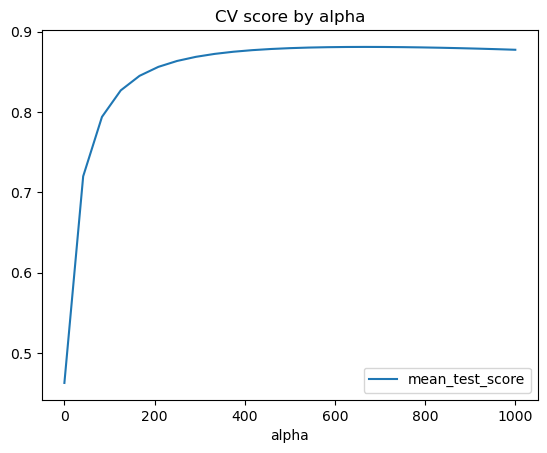

In [54]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

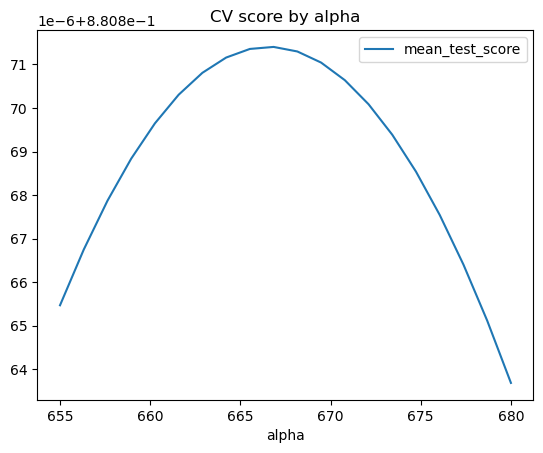

In [59]:
alphas = list(np.linspace(655, 680,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [60]:
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 666.84211


In [61]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: 0.88087


In [58]:
cv = KFold(10)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['gender']),
    remainder="drop",
)


In [71]:
import warnings

# ignore the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_selection import SelectPercentile, f_regression

pipe = Pipeline([('columntransformer',preproc_pipe),
                 ('feature_select',SelectPercentile(score_func=f_regression)), 
                 ('clf', Ridge())
                ])

param_grid = {
    # 'feature_select__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'feature_select__percentile': [90, 91, 92, 93, 94, 95, 96, 97],
    # 'feature_select__percentile': [18, 19, 20, 21, 22, 23, 24, 25],

    'clf__alpha': [665, 665.5, 666, 667, 668], 
    # 'clf__alpha': [0.5, 0.75, 0.9, 1.23, 1.45], 
    # 'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 
    # 'clf__alpha': [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05], 

    # 'clf__alpha': [165, 167, 168, 170, 171.05263, 172, 173, 174], 
    # 'clf__alpha': [40, 41, 42, 43, 44, 45, 46, 47], 
    # 'clf__alpha': [14.5,15,15.5,16, 16.5, 17], 
        # 'feature_select__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    # 'feature_select__percentile': [90, 91, 92, 93, 94, 95, 96, 97],
    # 'feature_select__percentile': [83, 84, 85, 86, 87, 88, 89, 90],
    # 'feature_select__percentile': [57, 58, 59 ,60, 61, 62, 63, 64],
    # 'feature_select__percentile': [64, 65, 66, 67, 68, 69 ,70, 71],

    # 'feature_select__percentile': [18, 19, 20, 21, 22, 23, 24, 25],

    # 'clf__alpha': [18, 19, 20, 21, 22, 23, 24, 25], 
    # 'clf__alpha': [0.5, 0.75, 0.9, 1.23, 1.45, 1.57895, 1.7, 1.8],
    # 'clf__alpha': [200, 205, 208, 210, 213, 215, 220, 225],
    # 'clf__alpha': [234, 236, 237, 238, 239 ,240],
    # 'clf__alpha': [120, 130, 140, 150, 160], 
    # 'clf__alpha': [114, 115, 116, 117, 118, 119, 120], 
    # 'clf__alpha': [50, 100, 150, 200, 250, 300], 
    # 'clf__alpha': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104], 

    # 'clf__alpha': [186, 188, 190, 192, 194, 196], 
    # 'clf__alpha': [105, 107, 109, 111, 112, 113, 114, 115], 
    # 'clf__alpha': [14.5,15,15.5,16, 16.5, 17], 
    # 'clf__alpha': [47, 48, 49, 50, 51, 52, 53, 54], 
# 

}

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)


In [72]:
results_data = pd.DataFrame(results.cv_results_)
results_data = results_data[['params','mean_test_score','std_test_score']]
results_data['alpha'] = results_data['params'].apply(lambda x: x.get('clf__alpha'))
results_data['k'] = results_data['params'].apply(lambda x: x.get('feature_select__percentile'))
results_data.describe()

,mean_test_score,std_test_score,alpha,k
count,40.000000,40.000000,40.000000,40.000000
mean,0.883288,0.211803,666.300000,93.500000
std,0.003160,0.014933,1.090754,2.320477
min,0.880871,0.192654,665.000000,90.000000
25%,0.880871,0.192822,665.500000,91.750000
50%,0.880871,0.223102,666.000000,93.500000
75%,0.887310,0.223268,667.000000,95.250000
max,0.887327,0.223357,668.000000,97.000000


Text(0    0.192855
Name: std_test_score, dtype: float64, 0    0.887327
Name: mean_test_score, dtype: float64, 'Best params: k=90, alpha=665     ')

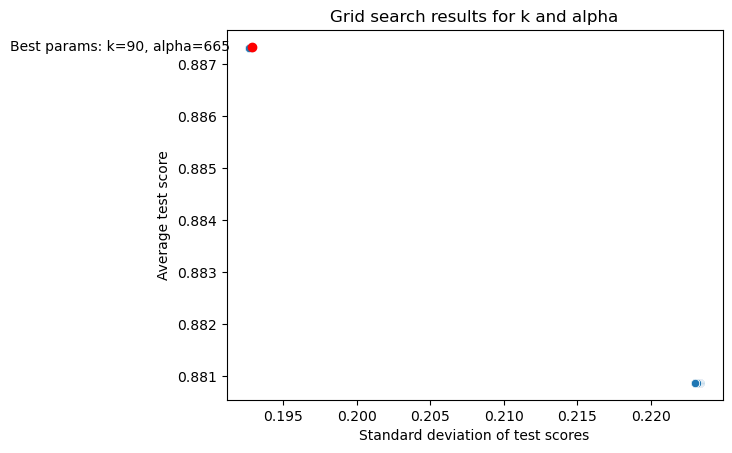

In [73]:
sns.scatterplot(data=results_data, x='std_test_score', y='mean_test_score')
plt.xlabel('Standard deviation of test scores')
plt.ylabel('Average test score')
plt.title('Grid search results for k and alpha')

best_params = grid_search.best_params_
best_k = best_params['feature_select__percentile']
best_alpha = best_params['clf__alpha']
plt.scatter(x=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'], 
            y=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'mean_test_score'], color='red')
plt.text(results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'],
         results_data.loc[(results_data['k'] == best_k) 
                                & (results_data['alpha'] == best_alpha),
                                'mean_test_score'], 
         f"Best params: k={best_k}, alpha={best_alpha}     ", ha='right', va='center')

In [74]:
opt_pipe = make_pipeline(preproc_pipe, SelectPercentile(score_func=f_regression, percentile=best_k), Ridge(alpha=best_alpha))
opt_pipe.fit(X_train, y_train)

y_holdout_pred = opt_pipe.predict(holdout_X)

# create a dataframe with the parcel ID and the predicted values
df_out = pd.DataFrame({'signature_index': VarY['signature_index'], 'prediction': np.exp(y_holdout_pred) })
# merged_df = pd.merge(VarY, df_out, on='signature_index')

In [75]:
df_out.to_csv('./Saved/pred_large_ceo_df.csv', index=False)